In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sklearn utilities
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.preprocessing import robust_scale

# sklearn models
from sklearn.ensemble import RandomForestRegressor

# Inputing Files

In [2]:
county_area = pd.read_csv('county_area.csv')
county_area = county_area.drop(["Areaname"], axis=1)
county_area = county_area.rename(columns={"STCOU": "fips"})

In [3]:
county_mask_use = pd.read_csv('mask_use.csv')
county_mask_use = county_mask_use.rename(columns={"COUNTYFP": "fips"})

In [4]:
county_cases = pd.read_csv('county_cases.csv')
county_cases = county_cases.drop(["county","state"], axis=1)

In [5]:
county_pop = pd.read_csv('county_pop.csv', encoding='latin-1')
county_pop = county_pop.drop(['STNAME','CTYNAME'], axis=1)
county_pop = county_pop.rename(columns={"COUNTY": "fips"})

## Merging Dataframes Together

In [6]:
df = county_pop.merge(county_mask_use, how='left', on="fips")
df = df.merge(county_area, how="left", on="fips")
df = df.merge(county_cases, how="left", on="fips")
df

,fips,POPESTIMATE2019,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,AREA,cases,deaths
0,1001,55869,0.053,0.074,0.134,0.295,0.444,604.49,2059,31
1,1003,223234,0.083,0.059,0.098,0.323,0.436,2027.08,6658,69
2,1005,24686,0.067,0.121,0.120,0.201,0.491,904.59,1033,9
3,1007,22394,0.020,0.034,0.096,0.278,0.572,625.50,840,14
4,1009,57826,0.053,0.114,0.180,0.194,0.459,650.65,1932,25
...,...,...,...,...,...,...,...,...,...,...
3123,56037,42343,0.061,0.295,0.230,0.146,0.268,10491.73,462,2
3124,56039,23464,0.095,0.157,0.160,0.247,0.340,4221.96,747,1
3125,56041,20226,0.098,0.278,0.154,0.207,0.264,2087.66,431,3
3126,56043,7805,0.204,0.155,0.069,0.285,0.287,2242.85,144,7


## Create Features

In [7]:
df['POP_DEN'] = df['POPESTIMATE2019'] / df['AREA']
#df['POP_DENxALWAYS'] = df['POP_DEN'] * df['ALWAYS']
#df['POP_DENxFREQUENTLY'] =df['POP_DEN'] * df['FREQUENTLY']
#df['POP_DENxSOMETIMES'] = df['POP_DEN'] * df['SOMETIMES']
#df['POP_DENxRARELY'] = df['POP_DEN'] * df['RARELY']
#df['POP_DENxNEVER'] = df['POP_DEN'] * df['NEVER']
#df['POPxALWAYS'] = df['POPESTIMATE2019'] * df['ALWAYS']
#df['POPxFREQUENTLY'] =df['POPESTIMATE2019'] * df['FREQUENTLY']
#df['POPxSOMETIMES'] = df['POPESTIMATE2019'] * df['SOMETIMES']
#df['POPxRARELY'] = df['POPESTIMATE2019'] * df['RARELY']
#df['POPxNEVER'] = df['POPESTIMATE2019'] * df['NEVER']
df = df.reindex(columns=["fips","cases","deaths","POPESTIMATE2019","AREA","POP_DEN","NEVER","RARELY","SOMETIMES","FREQUENTLY","ALWAYS"])
df.corr()

,fips,cases,deaths,POPESTIMATE2019,AREA,POP_DEN,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
fips,1.000000,-0.061754,-0.060394,-0.059759,-0.095848,0.047470,-0.005946,-0.032730,-0.053094,-0.079669,0.067678
cases,-0.061754,1.000000,0.901118,0.948347,0.033832,0.357263,-0.154615,-0.171201,-0.160765,-0.125457,0.235681
deaths,-0.060394,0.901118,1.000000,0.882777,0.020698,0.441297,-0.164789,-0.189642,-0.182864,-0.152364,0.265965
POPESTIMATE2019,-0.059759,0.948347,0.882777,1.000000,0.033140,0.399141,-0.197458,-0.212442,-0.207021,-0.146798,0.293856
AREA,-0.095848,0.033832,0.020698,0.033140,1.000000,-0.049577,-0.031426,-0.023864,-0.043233,0.095512,-0.002344
POP_DEN,0.047470,0.357263,0.441297,0.399141,-0.049577,1.000000,-0.186194,-0.208296,-0.196193,-0.115999,0.271051
NEVER,-0.005946,-0.154615,-0.164789,-0.197458,-0.031426,-0.186194,1.000000,0.427057,0.321972,0.048232,-0.684970
RARELY,-0.032730,-0.171201,-0.189642,-0.212442,-0.023864,-0.208296,0.427057,1.000000,0.361163,0.144707,-0.728386
SOMETIMES,-0.053094,-0.160765,-0.182864,-0.207021,-0.043233,-0.196193,0.321972,0.361163,1.000000,0.073084,-0.668399
FREQUENTLY,-0.079669,-0.125457,-0.152364,-0.146798,0.095512,-0.115999,0.048232,0.144707,0.073084,1.000000,-0.515229


## Normalize Data

In [8]:
def normalize(column):
    normal = []
    for value in column:
        value = (value - min(column)) / (max(column) - min(column))
        normal.append(value)
    return normal

In [9]:
def new_normal(dataframe):
    normal = robust_scale(dataframe)
    return normal

## df with outliers eliminated

In [10]:
df_outliers = df.drop(df[df['cases']>=20000].index, axis=0)
column_titles = ["POPESTIMATE2019","NEVER","RARELY","SOMETIMES","FREQUENTLY","ALWAYS","AREA","POP_DEN"]
df_outliers = new_normal(df_outliers.reindex(columns=column_titles))
df_outliers = pd.DataFrame(df_outliers)
df_outliers.columns = column_titles
df_outliers['fips'] = df['fips']
df_outliers = df_outliers.merge(county_cases, how="left", on="fips")
column_titles = ["fips","cases","deaths","POPESTIMATE2019","NEVER","RARELY","SOMETIMES","FREQUENTLY","ALWAYS","AREA","POP_DEN"]
df_outliers = df_outliers.reindex(columns=column_titles)

## normal df

In [11]:
column_titles = ["POPESTIMATE2019","NEVER","RARELY","SOMETIMES","FREQUENTLY","ALWAYS","AREA","POP_DEN"]#,"POP_DENxALWAYS","POP_DENxFREQUENTLY","POP_DENxSOMETIMES","POP_DENxRARELY","POP_DENxNEVER",'POPxALWAYS','POPxFREQUENTLY','POPxSOMETIMES','POPxRARELY','POPxNEVER']
normal_df = pd.DataFrame(new_normal(df.reindex(columns=column_titles)))
normal_df.columns = column_titles
normal_df['fips'] = df['fips']
normal_df = normal_df.merge(county_cases, how="left", on="fips")
column_titles = ["fips","cases","deaths","POPESTIMATE2019","NEVER","RARELY","SOMETIMES","FREQUENTLY","ALWAYS","AREA","POP_DEN"]#,"POP_DENxALWAYS","POP_DENxFREQUENTLY","POP_DENxSOMETIMES","POP_DENxRARELY","POP_DENxNEVER",'POPxALWAYS','POPxFREQUENTLY','POPxSOMETIMES','POPxRARELY','POPxNEVER']
normal_df = normal_df.reindex(columns=column_titles)

## Histogram of preprocessing

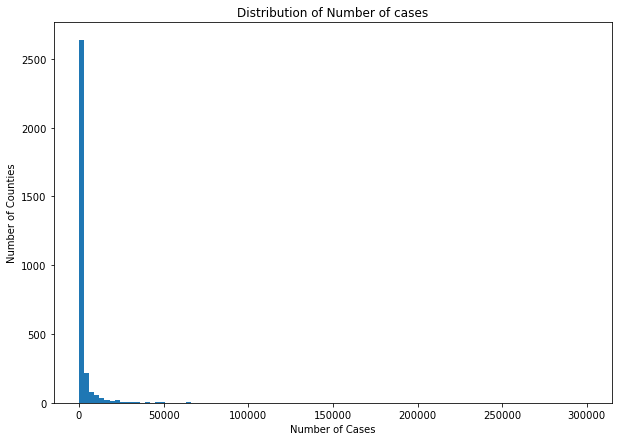

In [12]:
fig, ax = plt.subplots(figsize=(10,7))
plt.hist(df['cases'],bins=100)
plt.ylabel('Number of Counties') 
plt.xlabel('Number of Cases')
plt.title('Distribution of Number of cases')
plt.show()

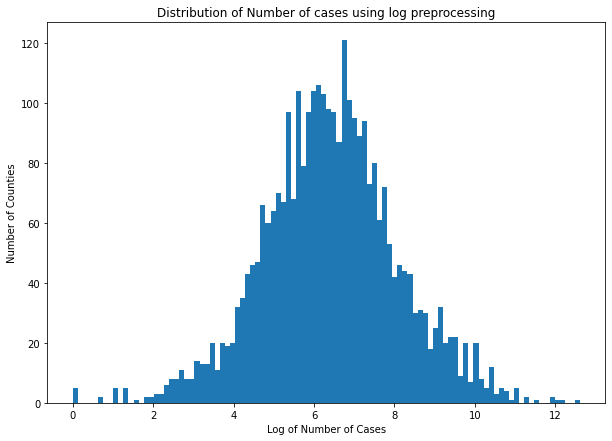

In [13]:
fig, ax = plt.subplots(figsize=(10,7))
plt.hist(np.log(normal_df['cases']),bins=100)
plt.ylabel('Number of Counties') 
plt.xlabel('Log of Number of Cases')
plt.title('Distribution of Number of cases using log preprocessing')
plt.show()

## Split Data

In [14]:
def split(X, Y, size):
    return train_test_split(X, Y, test_size=size, random_state=0)

## Random Forest Regression

In [15]:
x_df = normal_df.drop(['fips','cases','deaths'], axis=1)
x_train, x_test, y_train, y_test = split(x_df, np.log(normal_df['cases']), 0.2)

In [16]:
sizes = np.arange(30, 201, 10)
outs=[]
for size in sizes:
    clf = RandomForestRegressor(n_estimators=size)
    clf.fit(x_train, y_train)
    outs.append(MSE(clf.predict(x_test), y_test))
best_size = sizes[outs.index(min(outs))]
print('Best forest size is:', best_size)
print('With average MSE of:', min(outs))

Best forest size is: 170
With average MSE of: 0.45910358587518885


In [17]:
percents = np.arange(0.1, 1, 0.1)
outs=[]
for percent in percents:
    clf = RandomForestRegressor(n_estimators=best_size, bootstrap=True, max_samples=percent)
    clf.fit(x_train, y_train)
    outs.append(MSE(clf.predict(x_test), y_test))
clf = RandomForestRegressor(n_estimators=best_size)
clf.fit(x_train, y_train)
boot_off = MSE(clf.predict(x_test), y_test)
outs.append(boot_off)
if boot_off == min(outs):
    ideal_samples = 1
else:
    ideal_samples = sizes[outs.index(min(outs))]
print('Best sample size is:', ideal_samples)
print('With average MSE of:', min(outs))

Best sample size is: 50
With average MSE of: 0.4484900191138123


0.47525540350254725


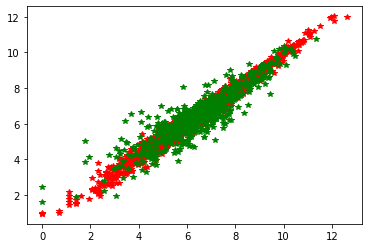

In [18]:
clf = RandomForestRegressor(n_estimators=50)
clf.fit(x_train, y_train)
y_train_pred = clf.predict(x_train)
y_test_pred = clf.predict(x_test)
print(MSE(clf.predict(x_test), y_test))
plt.plot(y_train, y_train_pred,'*r')
plt.plot(y_test, y_test_pred, '*g')


#for i in range(0,1000):
    #plt.plot(i/100,i/100,'*y')
plt.show()

In [21]:
(np.std(y_test)**2 - min(outs)) / np.std(y_test)**2

0.823340874272705